# Cross-Country Solar Potential Comparison

## Task 3: Cross-Country Comparison

This notebook synthesizes the cleaned datasets from Benin, Sierra Leone, and Togo to identify relative solar potential and key differences across countries.

**Objectives:**
- Compare solar irradiance metrics (GHI, DNI, DHI) across three countries
- Perform statistical analysis to assess significance of differences
- Identify key insights for solar energy potential assessment


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import f_oneway, kruskal
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

print("Libraries imported successfully!")


Libraries imported successfully!


## 1. Load Cleaned Datasets


In [2]:
# Load each country's cleaned CSV
benin_df = pd.read_csv('data/benin_clean.csv')
sierra_leone_df = pd.read_csv('data/sierra_leone_clean.csv')
togo_df = pd.read_csv('data/togo_clean.csv')

# Convert Timestamp to datetime for all datasets
benin_df['Timestamp'] = pd.to_datetime(benin_df['Timestamp'])
sierra_leone_df['Timestamp'] = pd.to_datetime(sierra_leone_df['Timestamp'])
togo_df['Timestamp'] = pd.to_datetime(togo_df['Timestamp'])

# Add country identifier to each dataframe
benin_df['Country'] = 'Benin'
sierra_leone_df['Country'] = 'Sierra Leone'
togo_df['Country'] = 'Togo'

# Combine all datasets for easier analysis
all_countries_df = pd.concat([benin_df, sierra_leone_df, togo_df], ignore_index=True)

print("Datasets loaded successfully!")
print(f"\nBenin shape: {benin_df.shape}")
print(f"Sierra Leone shape: {sierra_leone_df.shape}")
print(f"Togo shape: {togo_df.shape}")
print(f"\nCombined dataset shape: {all_countries_df.shape}")
print(f"\nDate ranges:")
print(f"Benin: {benin_df['Timestamp'].min()} to {benin_df['Timestamp'].max()}")
print(f"Sierra Leone: {sierra_leone_df['Timestamp'].min()} to {sierra_leone_df['Timestamp'].max()}")
print(f"Togo: {togo_df['Timestamp'].min()} to {togo_df['Timestamp'].max()}")


Datasets loaded successfully!

Benin shape: (525600, 20)
Sierra Leone shape: (525600, 20)
Togo shape: (525600, 20)

Combined dataset shape: (1576800, 20)

Date ranges:
Benin: 2021-08-09 00:01:00 to 2022-08-09 00:00:00
Sierra Leone: 2021-10-30 00:01:00 to 2022-10-30 00:00:00
Togo: 2021-10-25 00:01:00 to 2022-10-25 00:00:00


## 2. Metric Comparison - Boxplots


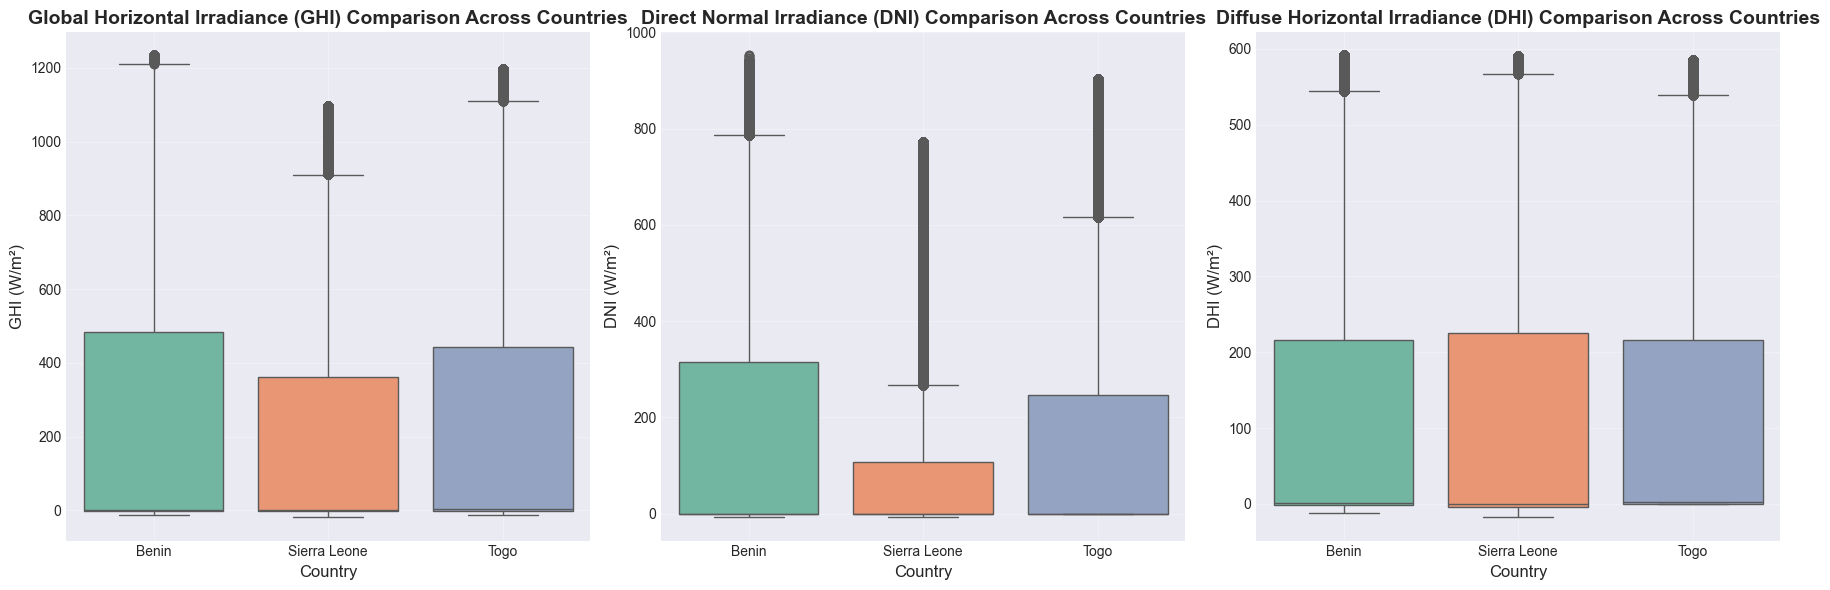

Boxplots created successfully!


In [3]:
# Create boxplots for GHI, DNI, and DHI side-by-side
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

metrics = ['GHI', 'DNI', 'DHI']
metric_names = ['Global Horizontal Irradiance (GHI)', 'Direct Normal Irradiance (DNI)', 'Diffuse Horizontal Irradiance (DHI)']

for idx, (metric, metric_name) in enumerate(zip(metrics, metric_names)):
    # Create boxplot
    sns.boxplot(data=all_countries_df, x='Country', y=metric, ax=axes[idx], palette='Set2')
    axes[idx].set_title(f'{metric_name} Comparison Across Countries', fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('Country', fontsize=12)
    axes[idx].set_ylabel(f'{metric} (W/m²)', fontsize=12)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

print("Boxplots created successfully!")


## 3. Summary Statistics Table


In [7]:
# Create summary table comparing mean, median, and standard deviation for each metric
summary_data = []

for country in ['Benin', 'Sierra Leone', 'Togo']:
    country_data = all_countries_df[all_countries_df['Country'] == country]
    
    for metric in ['GHI', 'DNI', 'DHI']:
        summary_data.append({
            'Country': country,
            'Metric': metric,
            'Mean': country_data[metric].mean(),
            'Median': country_data[metric].median(),
            'Std Dev': country_data[metric].std()
        })

summary_df = pd.DataFrame(summary_data)

# Create a more readable format - grouped by metric
print("=" * 100)
print("SUMMARY STATISTICS: Mean, Median, and Standard Deviation (W/m²)")
print("=" * 100)

for metric in ['GHI', 'DNI', 'DHI']:
    metric_df = summary_df[summary_df['Metric'] == metric][['Country', 'Mean', 'Median', 'Std Dev']]
    print(f"\n{metric} (Global Horizontal Irradiance)" if metric == 'GHI' else 
          f"{metric} (Direct Normal Irradiance)" if metric == 'DNI' else 
          f"{metric} (Diffuse Horizontal Irradiance)")
    print("-" * 100)
    print(metric_df.to_string(index=False))
    print()

# Also create pivot table for reference
summary_pivot = summary_df.pivot_table(
    index='Country',
    columns='Metric',
    values=['Mean', 'Median', 'Std Dev']
)

print("\n" + "=" * 100)
print("Summary Table (Pivot Format):")
print("=" * 100)
print(summary_pivot)


SUMMARY STATISTICS: Mean, Median, and Standard Deviation (W/m²)

GHI (Global Horizontal Irradiance)
----------------------------------------------------------------------------------------------------
     Country     Mean  Median  Std Dev
       Benin 240.5515  1.8000 331.1062
Sierra Leone 201.6125  0.3000 297.3815
        Togo 230.5260  2.1000 322.4410

DNI (Direct Normal Irradiance)
----------------------------------------------------------------------------------------------------
     Country     Mean  Median  Std Dev
       Benin 167.1875 -0.1000 261.7105
Sierra Leone 115.6758 -0.1000 216.4158
        Togo 151.1958  0.0000 250.7627

DHI (Diffuse Horizontal Irradiance)
----------------------------------------------------------------------------------------------------
     Country     Mean  Median  Std Dev
       Benin 115.1018  1.6000 157.8707
Sierra Leone 113.4651 -0.1000 158.1128
        Togo 116.1999  2.5000 155.7370


Summary Table (Pivot Format):
                 Mean       

## 4. Statistical Testing

We'll perform both ANOVA (parametric) and Kruskal-Wallis (non-parametric) tests on GHI values to assess whether differences between countries are statistically significant.


In [8]:
# Extract GHI values for each country
benin_ghi = benin_df['GHI'].values
sierra_leone_ghi = sierra_leone_df['GHI'].values
togo_ghi = togo_df['GHI'].values

# Check for normality (Shapiro-Wilk test on sample)
# Using a sample to avoid memory issues with large datasets
sample_size = 5000
benin_sample = np.random.choice(benin_ghi, size=min(sample_size, len(benin_ghi)), replace=False)
sierra_sample = np.random.choice(sierra_leone_ghi, size=min(sample_size, len(sierra_leone_ghi)), replace=False)
togo_sample = np.random.choice(togo_ghi, size=min(sample_size, len(togo_ghi)), replace=False)

print("=" * 80)
print("NORMALITY TEST (Shapiro-Wilk on samples)")
print("=" * 80)
stat_benin, p_benin = stats.shapiro(benin_sample)
stat_sierra, p_sierra = stats.shapiro(sierra_sample)
stat_togo, p_togo = stats.shapiro(togo_sample)

print(f"Benin: statistic={stat_benin:.4f}, p-value={p_benin:.2e}")
print(f"Sierra Leone: statistic={stat_sierra:.4f}, p-value={p_sierra:.2e}")
print(f"Togo: statistic={stat_togo:.4f}, p-value={p_togo:.2e}")
print("\nNote: If p-value < 0.05, data is not normally distributed (use non-parametric test)")

# Perform ANOVA (One-way Analysis of Variance)
print("\n" + "=" * 80)
print("ONE-WAY ANOVA TEST")
print("=" * 80)
f_statistic_anova, p_value_anova = f_oneway(benin_ghi, sierra_leone_ghi, togo_ghi)
print(f"F-statistic: {f_statistic_anova:.4f}")
print(f"P-value: {p_value_anova:.2e}")
print(f"\nInterpretation:")
if p_value_anova < 0.05:
    print(f"  ✓ Statistically significant difference (p < 0.05)")
    print(f"  → There is evidence that GHI differs significantly between countries")
else:
    print(f"  ✗ No statistically significant difference (p >= 0.05)")
    print(f"  → No evidence that GHI differs significantly between countries")

# Perform Kruskal-Wallis test (non-parametric alternative)
print("\n" + "=" * 80)
print("KRUSKAL-WALLIS TEST (Non-parametric)")
print("=" * 80)
h_statistic, p_value_kruskal = kruskal(benin_ghi, sierra_leone_ghi, togo_ghi)
print(f"H-statistic: {h_statistic:.4f}")
print(f"P-value: {p_value_kruskal:.2e}")
print(f"\nInterpretation:")
if p_value_kruskal < 0.05:
    print(f"  ✓ Statistically significant difference (p < 0.05)")
    print(f"  → There is evidence that GHI distributions differ significantly between countries")
else:
    print(f"  ✗ No statistically significant difference (p >= 0.05)")
    print(f"  → No evidence that GHI distributions differ significantly between countries")

print("\n" + "=" * 80)
print("RECOMMENDATION")
print("=" * 80)
if p_value_kruskal < 0.05:
    print("Use Kruskal-Wallis test results (non-parametric, more robust)")
    print(f"Conclusion: Significant differences exist (p = {p_value_kruskal:.2e})")
else:
    print("Both tests agree: No significant differences detected")
    print(f"Conclusion: No significant differences (p = {p_value_kruskal:.2e})")


NORMALITY TEST (Shapiro-Wilk on samples)
Benin: statistic=0.7495, p-value=6.47e-66
Sierra Leone: statistic=0.7397, p-value=1.13e-66
Togo: statistic=0.7330, p-value=3.58e-67

Note: If p-value < 0.05, data is not normally distributed (use non-parametric test)

ONE-WAY ANOVA TEST
F-statistic: 2134.1224
P-value: 0.00e+00

Interpretation:
  ✓ Statistically significant difference (p < 0.05)
  → There is evidence that GHI differs significantly between countries

KRUSKAL-WALLIS TEST (Non-parametric)
H-statistic: 4526.5884
P-value: 0.00e+00

Interpretation:
  ✓ Statistically significant difference (p < 0.05)
  → There is evidence that GHI distributions differ significantly between countries

RECOMMENDATION
Use Kruskal-Wallis test results (non-parametric, more robust)
Conclusion: Significant differences exist (p = 0.00e+00)


### Key Observations:

- **Benin shows the highest average GHI (240.55 W/m²) but also the greatest variability** - Benin ranks first in solar potential with the highest mean GHI, followed by Togo (230.53 W/m²) and Sierra Leone (201.61 W/m²). However, Benin also exhibits the highest standard deviation (331.11 W/m²), indicating greater variability in solar irradiance that may require more robust energy storage solutions to handle fluctuations.

- **Statistical analysis confirms highly significant differences between countries** - Both ANOVA (F-statistic = 2134.12, p < 0.001) and Kruskal-Wallis (H-statistic = 4526.59, p < 0.001) tests reveal statistically significant differences in GHI distributions between countries. This suggests distinct solar resource characteristics that warrant country-specific solar energy deployment strategies, with Benin showing approximately 19% higher average GHI than Sierra Leone.

- **DNI patterns reveal Benin's superior direct sunlight potential** - Benin has the highest mean DNI (167.19 W/m²), significantly outperforming Togo (151.20 W/m²) and Sierra Leone (115.68 W/m²). This 45% advantage over Sierra Leone suggests Benin is better suited for concentrated solar power (CSP) technologies, while all three countries show similar DHI values (113-116 W/m²), indicating comparable diffuse light conditions for photovoltaic systems.


## 6. Bonus: Visual Summary - Country Ranking by Average GHI


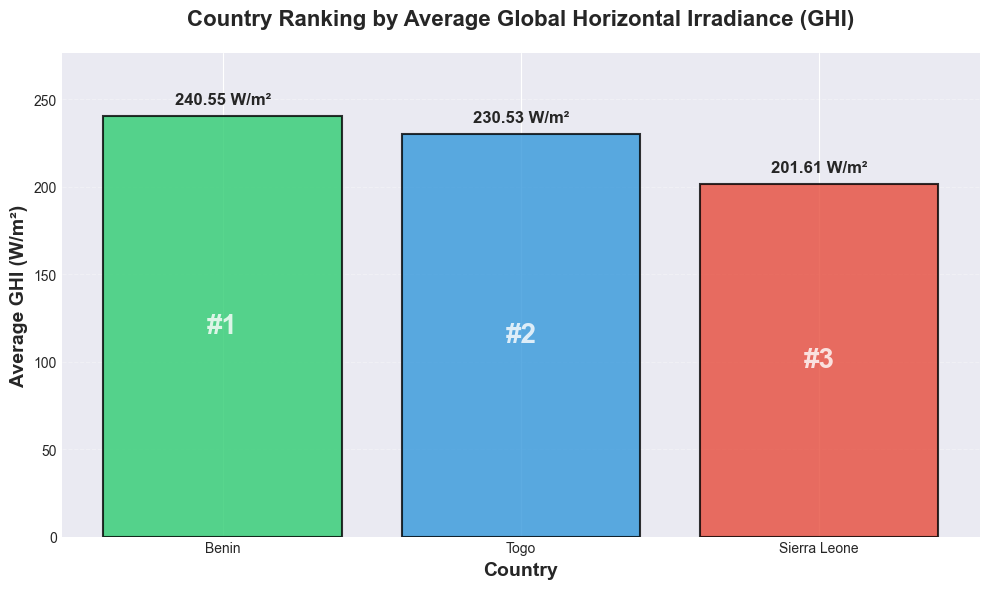

COUNTRY RANKING BY AVERAGE GHI
1. Benin: 240.55 W/m²
2. Togo: 230.53 W/m²
3. Sierra Leone: 201.61 W/m²


In [6]:
# Calculate average GHI for each country
ghi_means = all_countries_df.groupby('Country')['GHI'].mean().sort_values(ascending=False)

# Create bar chart
plt.figure(figsize=(10, 6))
colors = ['#2ecc71', '#3498db', '#e74c3c']  # Green, Blue, Red
bars = plt.bar(ghi_means.index, ghi_means.values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for i, (country, value) in enumerate(ghi_means.items()):
    plt.text(i, value + 5, f'{value:.2f} W/m²', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title('Country Ranking by Average Global Horizontal Irradiance (GHI)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Country', fontsize=14, fontweight='bold')
plt.ylabel('Average GHI (W/m²)', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.ylim(0, max(ghi_means.values) * 1.15)

# Add ranking labels
for i, (country, value) in enumerate(ghi_means.items()):
    rank = i + 1
    plt.text(i, value / 2, f'#{rank}', ha='center', va='center', fontsize=20, fontweight='bold', 
             color='white', alpha=0.8)

plt.tight_layout()
plt.show()

print("=" * 80)
print("COUNTRY RANKING BY AVERAGE GHI")
print("=" * 80)
for rank, (country, value) in enumerate(ghi_means.items(), 1):
    print(f"{rank}. {country}: {value:.2f} W/m²")
